In [1]:
from keratin.metrics import dice, dice_loss
import numpy as np
from keratin.networks import unet
from keras.optimizers import Adam
from skimage.transform import resize
import keras
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from skimage.transform import AffineTransform, matrix_transform, warp
#%pylab inline

Using TensorFlow backend.
Failed to import duecredit due to No module named 'duecredit'


In [2]:
def get_model():
    model = unet(256,256,n_channels=2)
    model.compile(optimizer=Adam(lr=10e-5), 
              loss=dice_loss, 
              metrics=[dice])
    return model

In [3]:
def make256(images, hints = None):
    
    if not hints:
        bigM = np.zeros((len(images), 256, 256, 1))
    else:
        bigM = np.zeros((len(images), 256, 256, 2))
    
    for i, im in enumerate(images):

        data = plt.imread(im)
        if len(data.shape) == 3:
            do_mean = True
            data = (data[:,:,0]/255).astype(np.float32)
            if hints:
                hint = plt.imread(hints[i]).astype(np.float32)
            
        else:
            do_mean = False
            #print("mean_data", np.mean(data))
            data = (data/np.max(data)).astype(np.float32)
            #print("mean data", np.mean(data))

        if data.shape[0] > 256:
            data = data[:256, :]
        if data.shape[1] > 256:
            data = data[:, :256]

        data_pad = np.pad(data, (((256-data.shape[0])//2, ((256-data.shape[0]) + (data.shape[0]%2 >0))//2), 
                                 ((256-data.shape[1])//2, ((256-data.shape[1]) + (data.shape[1]%2 >0))//2)), 
                          "constant", constant_values = (0,0))
        
        if hints:
            
            if hint.shape[0] > 256:
                hint = hint[:256, :]
            if hint.shape[1] > 256:
                hint = hint[:, :256]
            
            hint_pad = np.pad(hint, (((256-hint.shape[0])//2, ((256-hint.shape[0]) + (hint.shape[0]%2 >0))//2), 
                         ((256-hint.shape[1])//2, ((256-hint.shape[1]) + (hint.shape[1]%2 >0))//2)), 
                  "constant", constant_values = (0,0))

        
        if do_mean:
            bigM[i,:,:,0] = (data_pad - np.mean(data_pad)) / np.std(data_pad)
            if hints:
                bigM[i,:,:,1] = (hint_pad - np.mean(hint_pad)) / np.std(hint_pad)
            
            #bigM_mean = np.mean(bigM)
            #bigM_std = np.std(bigM)
            #bigM = (bigM - bigM_mean)/bigM_std
        else:
            bigM[i,:,:,0] = data_pad
        
    return bigM

In [4]:
images = sorted(glob("../tiles/*/base*.jpg"))
hints = sorted(glob("../tiles/*/agg*.png"))
masks =sorted(glob("../tiles/*/truth*.png"))
assert(len(images) == len(masks))
assert(len(hints) == len(masks))

In [5]:
subjects_all = [i.split("/")[-2] for i in images]
subjects = np.asarray(sorted(list(set(subjects_all))))

In [6]:
def get_data(images, hints, masks):
    bigM_base = make256(images, hints)
    print("base shape", bigM_base.shape)
    bigM_mask = make256(masks)
    print("mask shape", bigM_mask.shape)
    return bigM_base, bigM_mask

In [7]:
bigM_base, bigM_mask = get_data(images, hints, masks)

base shape (188, 256, 256, 2)
mask shape (188, 256, 256, 1)


In [8]:
def get_split_indices(subjects, subjects_all):
    idx = list(range(len(set(subjects))))
    np.random.shuffle(idx)
    train_subs = idx[:int(0.8*subjects.shape[0])]
    test_subs = idx[int(0.8*subjects.shape[0]):int(0.9*subjects.shape[0])]
    val_subs = idx[int(0.9*subjects.shape[0]):]
    train = [i for i, val in enumerate(subjects_all) if val in subjects[train_subs]]
    np.random.shuffle(train)
    test = [i for i, val in enumerate(subjects_all) if val in subjects[test_subs]]
    np.random.shuffle(test)
    val = [i for i, val in enumerate(subjects_all) if val in subjects[val_subs]]
    np.random.shuffle(val)
    return train, test, val

In [9]:
train, test, val = get_split_indices(subjects, subjects_all)

In [10]:
x_train = bigM_base[train, :]
y_train = bigM_mask[train, :]

x_test = bigM_base[test, :]
y_test = bigM_mask[test, :]

x_val = bigM_base[val, :]
y_val = bigM_mask[val, :]


In [11]:
x_train.shape

(136, 256, 256, 2)

**AK:** `killall python` to free up GPU memory (you only have 3.9GB)

`nvidia smi` to monitor usage

apparently this uses 3.4GB already

#### Data Augmentation

In [12]:
def get_random_affine():
    rotation = np.random.rand()*np.pi/45/2 * (np.random.binomial(1,0.5) * 2 - 1) # +- 4 degrees
    shear = np.random.rand()*np.pi/45/2 * (np.random.binomial(1,0.5) * 2 - 1) # +- 4 degrees
    translation = [t * (np.random.binomial(1,0.5) * 2 - 1) for t in np.random.rand(2) * 10] 
    scale = [1 + (t * (np.random.binomial(1,0.5) * 2 - 1)) for t in (np.random.rand(2) / 10)] 
    #print("r", rotation, "s", shear, "t", translation, "sc", scale)
    return AffineTransform(scale=scale, rotation=rotation, shear=shear, translation=translation)

In [13]:
def wiggle_image(data, truth):
    xfm = get_random_affine()
    return warp(data, xfm), warp(truth, xfm)

In [14]:
aug_num = 10 #

x_train_aug = x_train.copy()
y_train_aug = y_train.copy()

x_val_aug = x_val.copy()
y_val_aug = y_val.copy()


for i in range(aug_num):
    x_train_a, y_train_a = augment_data(x_train, y_train)
    x_val_a, y_val_a = augment_data(x_val, y_val)
    
    x_train_aug = np.vstack((x_train_aug, x_train_a))
    y_train_aug = np.vstack((y_train_aug, y_train_a))
    x_val_aug = np.vstack((x_val_aug, x_val_a))
    y_val_aug = np.vstack((y_val_aug, y_val_a))
    print(x_train_aug.shape, x_val_aug.shape)
    #break



(272, 256, 256, 2) (66, 256, 256, 2)
(408, 256, 256, 2) (99, 256, 256, 2)
(544, 256, 256, 2) (132, 256, 256, 2)
(680, 256, 256, 2) (165, 256, 256, 2)
(816, 256, 256, 2) (198, 256, 256, 2)
(952, 256, 256, 2) (231, 256, 256, 2)
(1088, 256, 256, 2) (264, 256, 256, 2)
(1224, 256, 256, 2) (297, 256, 256, 2)
(1360, 256, 256, 2) (330, 256, 256, 2)
(1496, 256, 256, 2) (363, 256, 256, 2)


### Remove some hints

**AK**: it wasn't happy with this

In [15]:
# randomly remove the hint in some images
count = 0
for i in range(x_train_aug.shape[0]):
    if np.random.binomial(1,0.1):
        count +=1
        x_train_aug[i,:,:,1] = 0
        
print(count/x_train_aug.shape[0]*100, "% removed")

count = 0
for i in range(x_val_aug.shape[0]):
    if np.random.binomial(1,0.1):
        count +=1
        x_val_aug[i,:,:,1] = 0
        
print(count/x_val_aug.shape[0]*100, "% removed")



8.890374331550802 % removed
12.396694214876034 % removed


### Weaken some hints

In [16]:
count = 0
for i in range(x_train_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_train_aug[i,:,:,1]
        x_train_aug[i,:,:,1], _ = wiggle_image(hint, hint)
        
print(count/x_train_aug.shape[0]*100, "% wiggled hints")

count = 0
for i in range(x_val_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_val_aug[i,:,:,1]
        x_val_aug[i,:,:,1], _ = wiggle_image(hint, hint)
        
print(count/x_val_aug.shape[0]*100, "% wiggled hints")


32.82085561497326 % wiggled hints
32.5068870523416 % wiggled hints


### Dilate and Erode some hints

**AK** It did not like this either!!

In [17]:
from skimage.morphology import dilation, erosion
from skimage.morphology import disk

def dilate_or_erode_image(img, do_dilate):
    if do_dilate:
        return dilation(img, disk(3))
    else:
        return erosion(img, disk(3))

In [18]:
count = 0
for i in range(x_train_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_train_aug[i,:,:,1]
        x_train_aug[i,:,:,1] = dilate_or_erode_image(hint, np.random.binomial(1,0.5))
        
print(count/x_train_aug.shape[0]*100, "% dilated or eroded hints")

count = 0
for i in range(x_val_aug.shape[0]):
    if np.random.binomial(1,0.3):
        count +=1
        hint = x_val_aug[i,:,:,1]
        x_val_aug[i,:,:,1] = dilate_or_erode_image(hint, np.random.binomial(1,0.5))
        
print(count/x_val_aug.shape[0]*100, "% dilated or eroded hints")


29.47860962566845 % dilated or eroded hints
29.75206611570248 % dilated or eroded hints


### Run the model

In [19]:
def get_new_log_dir():
    current_logs = sorted(glob("./log_try_????"))
    if len(current_logs) == 0:
        return "./log_try_0000"
    else:
        max_num = int(current_logs[-1].split("_")[-1])
        return "./log_try_%04d" % (max_num + 1)
    
def get_new_checkpoint_dir():
    current_logs = sorted(glob("./checkpoint_try_????"))
    if len(current_logs) == 0:
        return "./checkpoint_try_0000"
    else:
        max_num = int(current_logs[-1].split("_")[-1])
        return "./checkpoint_try_%04d" % (max_num + 1)

In [21]:
model = get_model()

/home/keshavan/software/keratin/keratin/networks.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  return km.Model(input=inputs, outputs=outputs)


In [22]:
model.fit(x_train_aug, y_train_aug, batch_size=4, 
          epochs=20, verbose=1, validation_data=(x_val_aug, y_val_aug), 
          callbacks=[keras.callbacks.TensorBoard(log_dir=get_new_log_dir(), histogram_freq=0, 
                                                 batch_size=4, write_graph=True, 
                                                 write_grads=True, write_images=True, 
                                                 embeddings_freq=0, embeddings_layer_names=None, 
                                                 embeddings_metadata=None),
                     keras.callbacks.ModelCheckpoint(get_new_checkpoint_dir(), monitor='val_dice', 
                                                     verbose=0, save_best_only=False, save_weights_only=False, 
                                                     mode='auto', period=1)
                    ]
)

Train on 1496 samples, validate on 363 samples
Epoch 1/20
1496/1496 [==============================] - 29s - loss: -0.6474 - dice: 0.6474 - val_loss: -0.7323 - val_dice: 0.7323
Epoch 2/20
1496/1496 [==============================] - 27s - loss: -0.7746 - dice: 0.7746 - val_loss: -0.7294 - val_dice: 0.7294
Epoch 3/20
1496/1496 [==============================] - 27s - loss: -0.7984 - dice: 0.7984 - val_loss: -0.7292 - val_dice: 0.7292
Epoch 4/20
1496/1496 [==============================] - 27s - loss: -0.8169 - dice: 0.8169 - val_loss: -0.7403 - val_dice: 0.7403
Epoch 5/20
1496/1496 [==============================] - 27s - loss: -0.8449 - dice: 0.8449 - val_loss: -0.7750 - val_dice: 0.7750
Epoch 6/20
1496/1496 [==============================] - 27s - loss: -0.8807 - dice: 0.8807 - val_loss: -0.8578 - val_dice: 0.8578
Epoch 7/20
1496/1496 [==============================] - 27s - loss: -0.9057 - dice: 0.9057 - val_loss: -0.8743 - val_dice: 0.8743
Epoch 8/20
1496/1496 [=====================

In [23]:
score = model.evaluate(x_test, y_test)
score

19/19 [==============================] - 0s


[-0.89173245429992676, 0.89173239469528198]

In [24]:
x_test_no_hint = x_test.copy()
x_test_no_hint[:,:,:,1] = 0

In [25]:
score_no_hint = model.evaluate(x_test_no_hint, y_test)
score_no_hint

19/19 [==============================] - 0s


[-0.8886721134185791, 0.88867205381393433]

In [26]:
x_test_no_brain = x_test.copy()
x_test_no_brain[:,:,:,0] = 0
score_no_brain = model.evaluate(x_test_no_brain, y_test)
score_no_brain

19/19 [==============================] - 0s


[-4.3244646803941578e-05, 4.3244646803941578e-05]

In [27]:
y_pred = model.predict(x_test)
y_pred_no_hint = model.predict(x_test_no_hint)
y_pred_no_brain = model.predict(x_test_no_brain)

In [28]:
assert(y_pred.shape==y_test.shape)

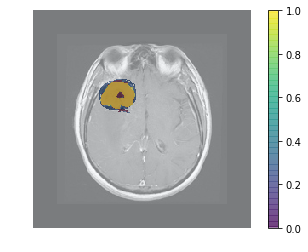

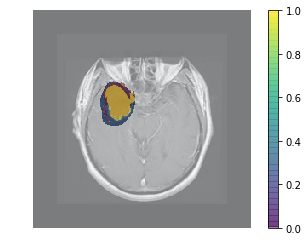

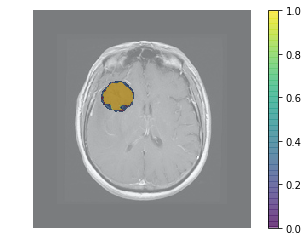

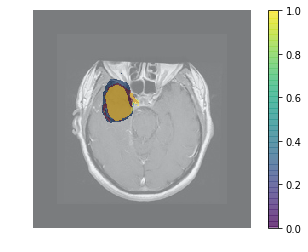

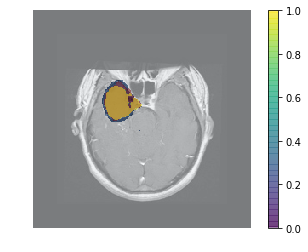

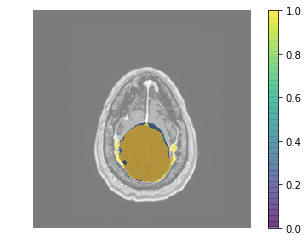

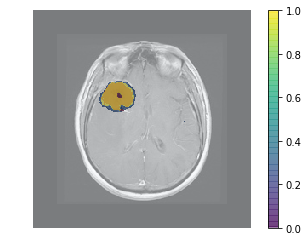

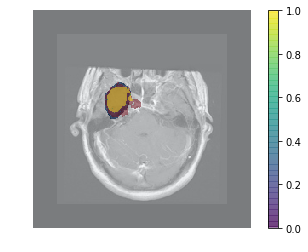

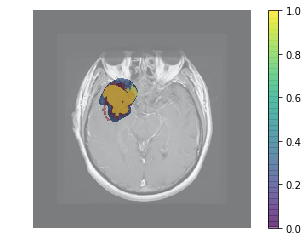

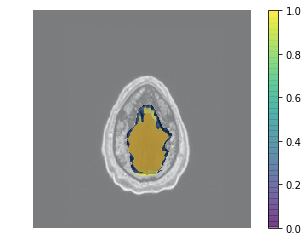

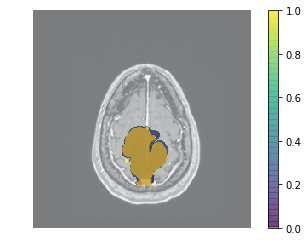

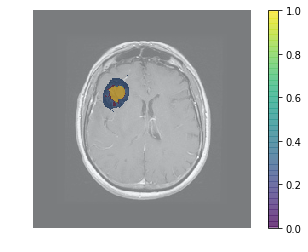

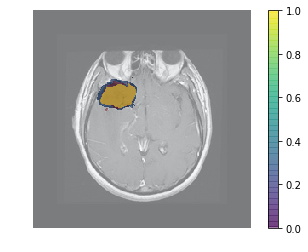

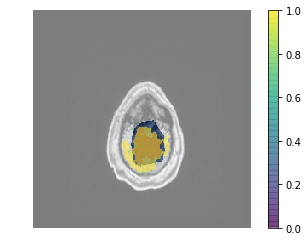

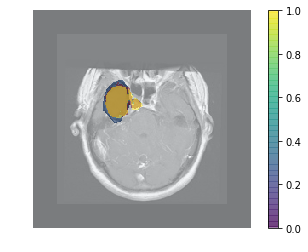

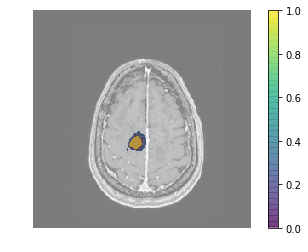

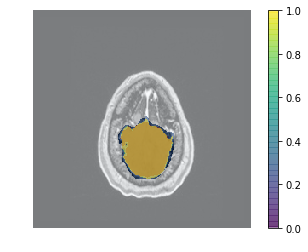

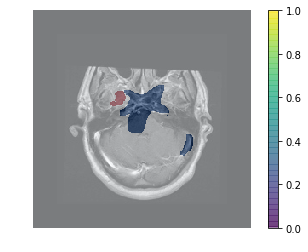

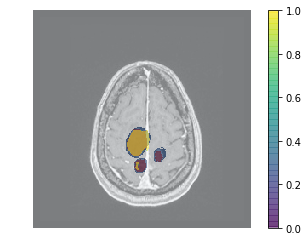

In [29]:
%matplotlib inline
for i in range(x_test.shape[0]):
    plt.figure(i)
    plt.imshow(x_test[i,:,:,0].reshape(256,256), cmap=plt.cm.Greys_r)
    
    hint = x_test[i,:,:,1].reshape(256,256)
    hint[hint==0] = np.nan
    plt.imshow(hint, cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    
    truth = y_test[i,:,:,0].reshape(256,256)
    truth[truth==0] = np.nan
    plt.imshow(truth, cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    roi = y_pred[i,:,:,0].reshape(256,256)
    roi[roi<0.5] = np.nan
    plt.imshow(roi, alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.colorbar()

In [30]:
len(subjects)

23

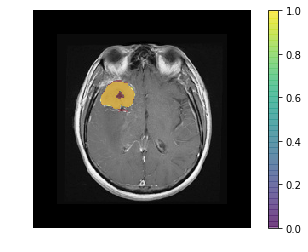

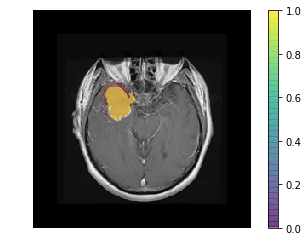

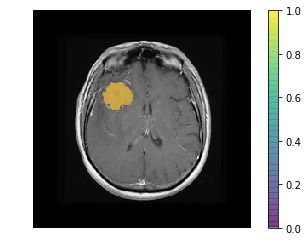

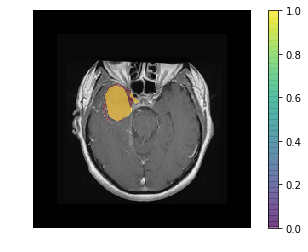

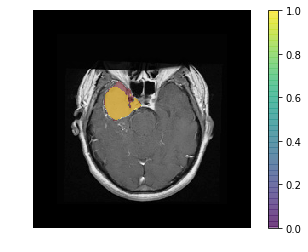

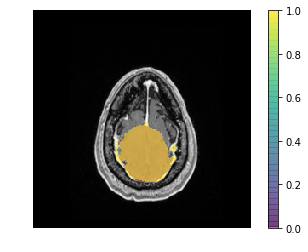

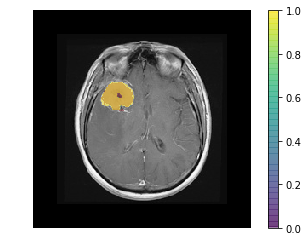

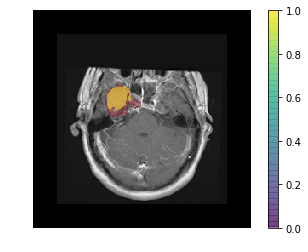

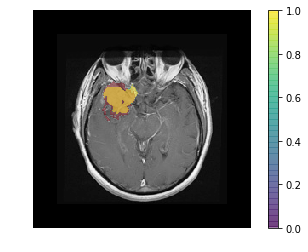

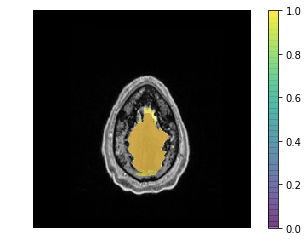

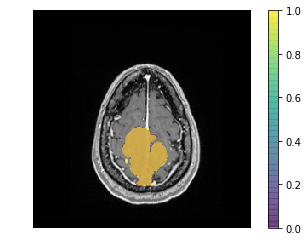

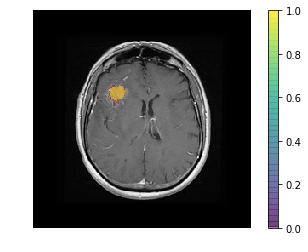

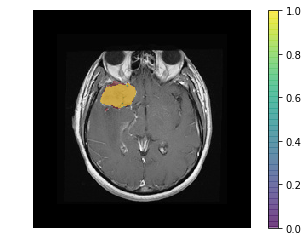

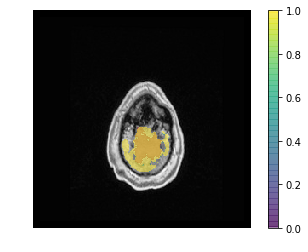

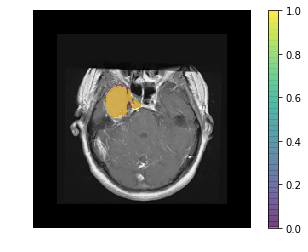

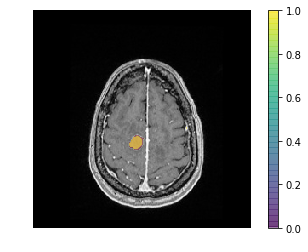

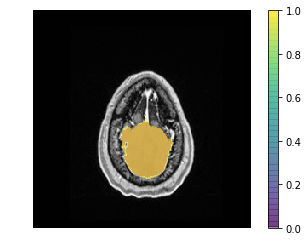

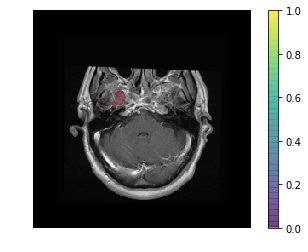

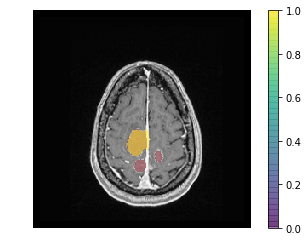

In [31]:
for i in range(x_test.shape[0]):
    plt.figure(i)
    plt.imshow(x_test[i,:,:,0].reshape(256,256), cmap=plt.cm.Greys_r)
    
    #hint = x_test[i,:,:,1].reshape(256,256)
    #hint[hint==0] = np.nan
    #plt.imshow(hint, cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    
    truth = y_test[i,:,:,0].reshape(256,256)
    truth[truth==0] = np.nan
    plt.imshow(truth, cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    roi = y_pred_no_hint[i,:,:,0].reshape(256,256)
    roi[roi<0.5] = np.nan
    plt.imshow(roi, alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.colorbar()

In [35]:
model.save("best_nohint_model.h5")

# run tensorboard

```bash
tensorboard --log ./logs
```

## TODOS:

* standardization
* add "hint" channel but smooth first
* bug satra to give more data